In [ ]:
import numpy as np
import pandas as pd
import joblib
import random

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from collections import defaultdict

In [ ]:
df = pd.read_csv("../0_data/1_processed/partidos_final.csv")

# Constantes y Features Finales  

Definimos las constantes del torneo y las 14 features que necesita el modelo, asegurando el orden exacto.

In [52]:
# --- CONSTANTES DEL MODELO FINAL ---
X_TRAIN_COLUMNS_FINAL = [
    'Elo_Diff', 'Elo_Surface_Diff', 'H2H_Advantage', 
    'Recent_Form_10_Diff', 'Age_Diff', 'Tournament_Titles_Diff_Dynamic', 
    'Grand_Titles_Diff_Dynamic', 'Round_Ordinal', 'Series_Ordinal', 
    'Court_Indoor', 'Best_of_5', 'Surface_Clay', 'Surface_Grass', 
    'Surface_Hard'
]

# --- CONSTANTES DEL TORNEO (US OPEN) ---
SERIES_ORDINAL_GS = 5
COURT_INDOOR = 0
BEST_OF_5 = 1
SURFACE_CLAY = 0
SURFACE_GRASS = 0
SURFACE_HARD = 1

# Funciones Auxiliares (Predicción y H2H)

In [ ]:
def create_h2h_cache(df_historico: pd.DataFrame, lista_jugadores: list) -> dict:
    """
    Crea un diccionario de cache para el Head-to-Head de todos los pares de jugadores.
    La clave es la tupla ordenada: ('Jugador A', 'Jugador B').
    """
    h2h_cache = {}
    
    # Iterar sobre todos los pares ÚNICOS de jugadores del cuadro
    for player1, player2 in combinations(lista_jugadores, 2):
        
        # Buscar en el DF histórico (SOLO ESTE PASO ES LENTO, Y SOLO SE HACE UNA VEZ)
        h2h_matches = df_historico[
            ((df_historico['Player_1'] == player1) & (df_historico['Player_2'] == player2)) |
            ((df_historico['Player_1'] == player2) & (df_historico['Player_2'] == player1))
        ].copy()

        if h2h_matches.empty:
            continue 
        
        # Contar Victorias
        p1_wins = (h2h_matches['Winner'] == player1).sum()
        p2_wins = (h2h_matches['Winner'] == player2).sum()
        
        # Almacenar el resultado con la clave canónica (tupla ordenada)
        key = tuple(sorted((player1, player2)))
        h2h_cache[key] = {'P1_Wins': p1_wins, 'P2_Wins': p2_wins}
        
    return h2h_cache

In [54]:
def lookup_h2h_advantage_CACHED(h2h_cache, player1, player2):
    """
    Busca la ventaja H2H en el cache pre-calculado, lo cual es instantáneo.
    Retorna (Victorias P1 - Victorias P2).
    """
    # 1. Crear la clave canónica (ordenada)
    key = tuple(sorted((player1, player2)))
    
    # 2. Buscar en el cache
    record = h2h_cache.get(key)
    
    if record is None:
        return 0 # No hay historial entre ellos
    
    # 3. Determinar la ventaja desde la perspectiva de P1 (P1 - P2)
    # Debemos verificar qué jugador corresponde a 'P1_Wins' en el registro
    if player1 == key[0]:
        return record['P1_Wins'] - record['P2_Wins']
    else:
        # El jugador 1 (P1) es el segundo elemento de la tupla.
        return record['P2_Wins'] - record['P1_Wins']

Generación del Vector de Features

In [55]:
def predecir_match_features_final(modelo, jugador_A_data, jugador_B_data, round_ordinal, h2h_cache):
    """
    Calcula el vector de 14 features de diferencia para el modelo y retorna la probabilidad de victoria de A.
    """
    
    data_vector = {
        # Habilidad Dinámica
        'Elo_Diff': [jugador_A_data['Elo_Absoluto'] - jugador_B_data['Elo_Absoluto']],
        'Elo_Surface_Diff': [jugador_A_data['Elo_Surface_Hard'] - jugador_B_data['Elo_Surface_Hard']],
        
        # Historial Directo (Lookup en el DF histórico)
        'H2H_Advantage': [lookup_h2h_advantage_CACHED(h2h_cache, jugador_A_data['Nombre'], jugador_B_data['Nombre'])],

        # Forma Reciente (Win Pct)
        'Recent_Form_10_Diff': [jugador_A_data['Forma_WinPct_Absoluto'] - jugador_B_data['Forma_WinPct_Absoluto']],
        
        # EXPERIENCIA ESTÁTICA
        'Age_Diff': [jugador_A_data['Age_Absoluta'] - jugador_B_data['Age_Absoluta']],
        'Tournament_Titles_Diff_Dynamic': [jugador_A_data['Titulos_Absoluto'] - jugador_B_data['Titulos_Absoluto']],
        'Grand_Titles_Diff_Dynamic': [jugador_A_data['Grand_Titles_Absoluto'] - jugador_B_data['Grand_Titles_Absoluto']],
        
        # CONTEXTO DEL TORNEO (CONSTANTES Y VARIABLES DE RONDA)
        'Round_Ordinal': [round_ordinal], 
        'Series_Ordinal': [SERIES_ORDINAL_GS], 
        'Court_Indoor': [COURT_INDOOR],
        'Best_of_5': [BEST_OF_5],
        'Surface_Clay': [SURFACE_CLAY],
        'Surface_Grass': [SURFACE_GRASS],
        'Surface_Hard': [SURFACE_HARD],
    }
    
    X_new = pd.DataFrame(data_vector, columns=X_TRAIN_COLUMNS_FINAL) 
    
    # Retorna la probabilidad de que gane P1 (Jugador A)
    return modelo.predict_proba(X_new)[0, 1]

Simulación Monte Carlo de un Partido

In [ ]:
def simular_partido_mc(proba_A_gana, nombre_A, nombre_B):
    """
    Decide el ganador de una simulación basado en la probabilidad (Monte Carlo).
    """
    r = random.random()
    
    if r < proba_A_gana:
        return nombre_A
    else:
        return nombre_B

# Función Principal: Simulación del Torneo

In [ ]:
def simular_torneo(modelo, cuadro_inicial, jugadores_data, h2h_cache, num_simulaciones=500):
    
    # Contenedor para contar victorias en la Final
    conteo_campeones = defaultdict(int)
    
    # Bucle principal de Monte Carlo
    for sim in range(num_simulaciones):
        
        # El cuadro comienza con los partidos de la Ronda 1
        cuadro_actual = [p.copy() for p in cuadro_inicial] 
        ronda_num = 1
        
        # Bucle de avance por rondas (R1 -> R2 -> ... -> Final)
        while len(cuadro_actual) >= 1:
            partidos_siguiente_ronda = []
            
            # 1. Simular todos los partidos de la ronda actual
            for partido in cuadro_actual:
                p1_name = partido["P1"]
                p2_name = partido["P2"]
                
                # Obtener la data absoluta de los jugadores (habilidad, edad, títulos)
                p1_data = jugadores_data.get(p1_name)
                p2_data = jugadores_data.get(p2_name)
                
                # 🚨 Control de jugadores no encontrados (ej. si no están en el DF histórico)
                if p1_data is None or p2_data is None:
                    # Asumimos que el jugador con data gana, o se le da 50%
                    ganador = p1_name if p2_data is None else p2_name
                else:
                    # 2. Calcular probabilidad de victoria de P1
                    proba_p1 = predecir_match_features_final(
                        modelo, p1_data, p2_data, ronda_num, h2h_cache
                    )
                    
                    # 3. Decidir el ganador por Monte Carlo
                    ganador = simular_partido_mc(proba_p1, p1_name, p2_name)
                
                partidos_siguiente_ronda.append(ganador)
            
            # 4. Condición de Parada: Campeón encontrado
            if len(partidos_siguiente_ronda) == 1:
                campeon = partidos_siguiente_ronda[0]
                conteo_campeones[campeon] += 1
                break
            
            # 5. Construir la siguiente ronda
            cuadro_actual = []
            for i in range(0, len(partidos_siguiente_ronda), 2):
                cuadro_actual.append(
                    {"P1": partidos_siguiente_ronda[i], "P2": partidos_siguiente_ronda[i+1]}
                )
            
            ronda_num += 1

    # 6. Resultados finales: convertir conteo a probabilidad (0.0 a 1.0)
    resultados = {
        jugador: conteo / num_simulaciones 
        for jugador, conteo in conteo_campeones.items()
    }
    return dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))

In [ ]:
def buscar_ultima_data_absoluta(df_historico: pd.DataFrame, nombre_jugador: str) -> dict:
    """
    Busca la última aparición de un jugador en el DF histórico y extrae sus 
    métricas absolutas (pre-torneo) necesarias para la simulación.
    """
    
    # Asegurarse de que el DF esté ordenado por fecha para tomar la última línea
    df = df_historico.sort_values(by='Date', ascending=False)
    
    # 1. Filtrar las filas donde el jugador aparece como P1 o P2
    df_player = df[
        (df['Player_1'] == nombre_jugador) | (df['Player_2'] == nombre_jugador)
    ].copy()
    
    if df_player.empty:
        # Esto ocurre si el jugador nunca ha jugado un partido en el histórico.
        return None 

    # 2. Tomar la última fila (la más reciente)
    ultima_fila = df_player.iloc[0]
    
    # 3. Determinar si el jugador fue P1 o P2 en ese último partido
    es_p1 = (ultima_fila['Player_1'] == nombre_jugador)
    
    # 4. Extracción de Métricas Absolutas
    
    # ** A) Métricas de Habilidad Absoluta (Elo) **
    # Tuvimos que inferir las columnas, asumimos que existen P1_Elo_Before/P2_Elo_Before
    # o que podemos inferirlas a partir de Elo_Diff
    
    # Usaremos una aproximación robusta: asumiremos que el Elo ABSOLUTO de ese 
    # último partido es el valor que el modelo ha aprendido.
    
    # NOTA: Debes tener la columna P1_Elo_Before/P2_Elo_Before en tu DF.
    # Si no la tienes, esto fallará y tendrás que volver a la etapa de Elo para guardarla.
    
    if 'P1_Elo_Before' not in df.columns:
        raise KeyError("La columna 'P1_Elo_Before' es requerida. Vuelve a calcular Elo en tu cuaderno 2 y guarda los scores absolutos.")

    # ELO General
    elo_abs = ultima_fila['P1_Elo_Before'] if es_p1 else ultima_fila['P2_Elo_Before']
    
    # ELO Surface Hard (Asumimos que el US Open es Hard)
    elo_hard = ultima_fila['P1_Elo_Surface'] if es_p1 else ultima_fila['P2_Elo_Surface']

    # ** B) Métricas de Forma Absoluta **
    # Asumimos que la forma se puede extraer del lado P1 o P2.
    # Nota: Wins_Last_5_Absoluto se eliminó del modelo final, por lo que solo usamos Recent_Form_10.
    
    # La forma se debe calcular *antes* de la predicción, pero si tu DF tiene P1_Recent_Win_Pct, úsalo.
    # Asumiremos que tenemos las columnas absolutas (ej. P1_Recent_Win_Pct)
    
    # NOTA: Debes tener la columna P1_Recent_Win_Pct en tu DF.
    if 'P1_Recent_Win_Pct' not in df.columns:
         raise KeyError("La columna 'P1_Recent_Win_Pct' es requerida. Vuelve a calcular Forma en tu cuaderno 2 y guarda los scores absolutos.")

    form_win_pct_10 = ultima_fila['P1_Recent_Win_Pct'] if es_p1 else ultima_fila['P2_Recent_Win_Pct']

    # ** C) Métricas Estáticas/Dinámicas (Títulos/Edad) **
    
    titulos_totales = ultima_fila['P1_Tournament_Titles_Dynamic'] if es_p1 else ultima_fila['P2_Tournament_Titles_Dynamic']
    titulos_grandes = ultima_fila['P1_Grand_Titles_Dynamic'] if es_p1 else ultima_fila['P2_Grand_Titles_Dynamic']
    edad_abs = ultima_fila['Age_Player1'] if es_p1 else ultima_fila['Age_Player2']

    # 5. Retornar el diccionario con las métricas absolutas
    return {
        "Nombre": nombre_jugador,
        "Elo_Absoluto": elo_abs,
        "Elo_Surface_Hard": elo_hard,
        "Forma_WinPct_Absoluto": form_win_pct_10,
        "Titulos_Absoluto": titulos_totales,
        "Grand_Titles_Absoluto": titulos_grandes,
        "Age_Absoluta": edad_abs,
    }


# ----------------------------------------------------------------------------------

def crear_diccionario_jugadores(df_historico, lista_jugadores: list) -> dict:
    """
    Crea el diccionario final de jugadores buscando las últimas métricas absolutas.
    """
    diccionario_final = {}
    
    for jugador in lista_jugadores:
        data = buscar_ultima_data_absoluta(df_historico, jugador)
        if data:
            diccionario_final[jugador] = data
        else:
            print(f"⚠️ Advertencia: Jugador {jugador} no encontrado en el historial. Ignorando.")
            # Si un jugador no está en el historial (ej. novato), puedes darle un ELO base (ej. 1500)
            
    return diccionario_final

# ----------------------------------------------------------------------------------

# Ejemplo de Uso (Necesitas tu DF original y la lista de jugadores del cuadro)

# Asumamos esta lista
lista_jugadores_usopen = ['Shevchenko A.', 'Davidovich Fokina A.',
                          'Rinderknech A.', 'Carballes Baena R.',
                          'Jarry N.', 'Mensik J.',
                          'Shelton B.', 'Buse I.',
                          'Nava E.', 'Fritz T.',
                          'Blanchet U.', 'Marozsan F.', 
                          'Dostanic S.', 'Spizzirri E.',
                          'Darderi L.', 'Hijikata R.',
                          'Coric B.', 'Lehecka J.',
                          'Mannarino A.', 'Griekspoor T.',
                          'Nardi L.', 'Machac T.',
                          'Svajda Z.', 'Piros Z.',
                          'Quinn E.', 'Kym J.',
                          'Carreno Busta P.', 'Llamas Ruiz P.',
                          'Ugo Carabelli C.', 'Etcheverry T.',
                          'Thompson J.', 'Moutet C.',
                          'Navone M.', 'Giron M.',
                          
                          'Nakashima B.', 'De Jong J.',
                          'Tien L.', 'Djokovic N.',
                          'Bonzi B.', 'Medvedev D.',
                          'Baez S.', 'Harris L.',
                          'Damm M.', 'Blanch D.',
                          'Kovacevic A.', 'Wong C.',
                          'Walton A.', 'Humbert U.',
                          'Garin C.', 'Bergs Z.', 
                          'Norrie C.', 'Korda S.',
                          'Kecmanovic M.', 'Fonseca J.',
                          'Draper J.', 'Gomez F.',
                          'Galan D.', 'Collignon R.',
                          'Comesana F.', 'Michelsen A.',
                          'Passaro F.', 'Cobolli F.',
                          'Bellucci M.', 'Shang J.',
                          'Vukic A.', 'Brooksby J.',
                          'Rune H.', 'Van De Zandschulp B.',
                          'Nishioka Y.', 'Tiafoe F.',
                          'Munar J.', 'Faria J.',
                          'Dellien H.', 'Majchrzak K.',
                          'Struff J.L.', 'Mcdonald M.',
                          'Duckworth J.', 'Boyer T.',
                          'Khachanov K.', 'Basavareddy N.',
                          'Prizmic D.', 'Rublev A.',
                          
                          'Ruud C.', 'Ofner S.',
                          'Dzumhur D.', 'Diallo G.',
                          'Alcaraz C.', 'Opelka R.',
                          'Fucsovics M.', 'Shapovalov D.',
                          'Cerundolo F.', 'Arnaldi M.', 
                          'Muller A.', 'Musetti L.',
                          'Goffin D.', 'Halys Q.',
                          'Cilic M.', 'Bublik A.',
                          'Riedi L.', 'Martinez P.',
                          'Kopriva V.', 'Sinner J.',
                          'Royer V.', 'Fearnley J.',
                          'Ruusuvuori E.', 'Popyrin A.',
                          'Auger-Aliassime F.', 'Harris B.',
                          'Gaston H.', 'Mochizuki S.',
                          'Altmaier D.', 'Medjedovic H.',
                          'Sonego L.', 'Schoolkate T.',
                          'Tsitsipas S.', 'Muller A.',
                          'Kecmanovic M.', 'De Minaur A.',
                          'Borges N.', 'Holt B.',
                          'Monfils G.', 'Safiullin R.',
                          
                          'Fearnley J.', 'Bautista Agut R.',
                          'Moller E.', 'Paul T.',
                          'Zverev A.', 'Tabilo A.'] 

diccionario_jugadores_simulacion = crear_diccionario_jugadores(df, lista_jugadores_usopen)

print(diccionario_jugadores_simulacion)

{'Shevchenko A.': {'Nombre': 'Shevchenko A.', 'Elo_Absoluto': np.float64(1550.641682187675), 'Elo_Surface_Hard': np.float64(1524.5812319877984), 'Forma_WinPct_Absoluto': np.float64(0.4), 'Titulos_Absoluto': np.float64(0.0), 'Grand_Titles_Absoluto': np.float64(0.0), 'Age_Absoluta': np.float64(2000.0)}, 'Davidovich Fokina A.': {'Nombre': 'Davidovich Fokina A.', 'Elo_Absoluto': np.float64(1786.7428087946082), 'Elo_Surface_Hard': np.float64(1723.9246804777583), 'Forma_WinPct_Absoluto': np.float64(0.7), 'Titulos_Absoluto': np.float64(0.0), 'Grand_Titles_Absoluto': np.float64(0.0), 'Age_Absoluta': np.float64(1999.0)}, 'Rinderknech A.': {'Nombre': 'Rinderknech A.', 'Elo_Absoluto': np.float64(1638.5494809048969), 'Elo_Surface_Hard': np.float64(1535.6990652417874), 'Forma_WinPct_Absoluto': np.float64(0.6), 'Titulos_Absoluto': np.float64(0.0), 'Grand_Titles_Absoluto': np.float64(0.0), 'Age_Absoluta': np.float64(1995.0)}, 'Carballes Baena R.': {'Nombre': 'Carballes Baena R.', 'Elo_Absoluto': np.f

# CREACION DEL CUADRO INICIAL

In [59]:
cuadro_usopen2025 = [

# Partido 1 (Ganador va contra Ganador P2)
{"P1": "Kopriva V.", "P2": "Sinner J."},

# Partido 2
{"P1": "Popyrin A.", "P2": "Ruusuvuori E."},

 # Partido 3  (Ganador va contra Ganador P4)
{"P1": "Royer V.", "P2": "Fearnley J."},

# Partido 4
{"P1": "Fucsovics M.", "P2": "Shapovalov D."},

# Partido 5 (Ganador va contra Ganador P6)
{"P1": "Cilic M.", "P2": "Bublik A."},

# Partido 6 (Ganador va contra Ganador P7)
{"P1": "Sonego L.", "P2": "Schoolkate T."},

# Partido 7 (Ganador va contra Ganador P8)
{"P1": "Borges N.", "P2": "Holt B."},
 
# Partido 8
{"P1": "Moller E.", "P2": "Paul T."},
 
#
 
# Partido 9 (Ganador va contra Ganador P10)
{"P1": "Muller A.", "P2": "Musetti L."},
 
# Partido 10
{"P1": "Goffin D.", "P2": "Halys Q."},
 
 # Partido 11 (Ganador va contra Ganador P12)
{"P1": "Vukic A.", "P2": "Brooksby J."},
 
# Partido 12
{"P1": "Passaro F.", "P2": "Cobolli F."},

# Partido 13 (Ganador va contra Ganador P14)
{"P1": "Dzumhur D.", "P2": "Diallo G."},

# Partido 14
{"P1": "Munar J.", "P2": "Faria J."},

# Partido 15 (Ganador va contra Ganador P16)
{"P1": "Garin C.", "P2": "Bergs Z."},

# Partido 16
{"P1": "Draper J.", "P2": "Gomez F."},
 
#

# Partido 17 (Ganador va contra Ganador P18)
{"P1": "Zverev A.", "P2": "Tabilo A."},

# Partido 18
{"P1": "Fearnley J.", "P2": "Bautista Agut R."},

# Partido 19 (Ganador va contra Ganador P20)
{"P1": "Monfils G.", "P2": "Safiullin R."},

# Partido 20
{"P1": "Auger-Aliassime F.", "P2": "Harris B."},

# Partido 21 (Ganador va contra Ganador P22)
{"P1": "Walton A.", "P2": "Humbert U."},

# Partido 22
{"P1": "Kovacevic A.", "P2": "Wong C."},

# Partido 23 (Ganador va contra Ganador P24)
{"P1": "Duckworth J.", "P2": "Boyer T."},

# Partido 24
{"P1": "Prizmic D.", "P2": "Rublev A."},

#

# Partido 25 (Ganador va contra Ganador P26)
{"P1": "Khachanov K.", "P2": "Basavareddy N."},

# Partido 26
{"P1": "Dellien H.", "P2": "Majchrzak K."},

# Partido 27 (Ganador va contra Ganador P28)
{"P1": "Riedi L.", "P2": "Martinez P."},

# Partido 28
{"P1": "Cerundolo F.", "P2": "Arnaldi M."},
 
# Partido 29 (Ganador va contra Ganador P30)
{"P1": "Tsitsipas S.", "P2": "Muller A."},

# Partido 30
{"P1": "Altmaier D.", "P2": "Medjedovic H."},

# Partido 31 (Ganador va contra Ganador P32)
{"P1": "Gaston H.", "P2": "Mochizuki S."},

# Partido 32
{"P1": "Kecmanovic M.", "P2": "De Minaur A."},
 
#

# Partido 33 (Ganador va contra Ganador P34)
{"P1": "Tien L.", "P2": "Djokovic N."},

# Partido 34
{"P1": "Svajda Z.", "P2": "Piros Z."},

# Partido 35 (Ganador va contra Ganador P36)
{"P1": "Norrie C.", "P2": "Korda S."},
 
# Partido 36
{"P1": "Comesana F.", "P2": "Michelsen A."},

# Partido 37 (Ganador va contra Ganador P38)
{"P1": "Nishioka Y.", "P2": "Tiafoe F."},

# Partido 38
{"P1": "Damm M.", "P2": "Blanch D."},

# Partido 39 (Ganador va contra Ganador P40)
{"P1": "Struff J.L.", "P2": "Mcdonald M."},

# Partido 40
{"P1": "Rune H.", "P2": "Van De Zandschulp B."},

#

#Partido 41 (Ganador va contra Ganador P42)
{"P1": "Jarry N.", "P2": "Mensik J."},

# Partido 42
{"P1": "Blanchet U.", "P2": "Marozsan F."},
 
# Partido 43 (Ganador va contra Ganador P44)
{"P1": "Kecmanovic M.", "P2": "Fonseca J."},
 
# Partido 44
{"P1": "Nardi L.", "P2": "Machac T."},

# Partido 45 (Ganador va contra Ganador P46)
{"P1": "Nakashima B.", "P2": "De Jong J."},

# Partido 46
{"P1": "Quinn E.", "P2": "Kym J."},

# Partido 47 (Ganador va contra Ganador P48)
{"P1": "Baez S.", "P2": "Harris L."},

# Partido 48
{"P1": "Nava E.", "P2": "Fritz T."},

#

# Partido 49 (Ganador va contra Ganador P50)
{"P1": "Shelton B.", "P2": "Buse I."},

# Partido 50
{"P1": "Carreno Busta P.", "P2": "Llamas Ruiz P."},
 
# Partido 51 (Ganador va contra Ganador P52)
{"P1": "Thompson J.", "P2": "Moutet C."},

# Partido 52
{"P1": "Mannarino A.", "P2": "Griekspoor T."},

# Partido 53 (Ganador va contra Ganador P54)
{"P1": "Coric B.", "P2": "Lehecka J."},

# Partido 54
{"P1": "Ugo Carabelli C.", "P2": "Etcheverry T."},

# Partido 55 (Ganador va contra Ganador P56)
{"P1": "Galan D.", "P2": "Collignon R."},
 
# Partido 56
{"P1": "Ruud C.", "P2": "Ofner S."},
 
#

# Partido 57 (Ganador va contra Ganador P58)
{"P1": "Bonzi B.", "P2": "Medvedev D."},

# Partido 58
{"P1": "Navone M.", "P2": "Giron M."},

# Partido 59 (Ganador va contra Ganador P60)
{"P1": "Rinderknech A.", "P2": "Carballes Baena R."},

# Partido 60
{"P1": "Shevchenko A.", "P2": "Davidovich Fokina A."},

# Partido 61 (Ganador va contra Ganador P62)
{"P1": "Darderi L.", "P2": "Hijikata R."},
 
# Partido 62
{"P1": "Dostanic S.", "P2": "Spizzirri E."},
 
# Partido 63 (Ganador va contra Ganador P64)
{"P1": "Bellucci M.", "P2": "Shang J."},

# Partido 64
{"P1": "Alcaraz C.", "P2": "Opelka R."},

]

In [ ]:
# Definir el nombre de tu archivo (asegúrate de que la ruta sea correcta)
nombre_archivo = '../3_models/random_forest_modelofinalOK.joblib' 

# Cargar el modelo en la variable 'modelok'
try:
    modelofinalOK = joblib.load(nombre_archivo)
    
    # El modelo cargado es el Pipeline completo (Scaler + Random Forest)
    print(f"✅ Modelo '{nombre_archivo}' cargado exitosamente.")
    print(f"Tipo de objeto cargado: {type(modelofinalOK)}")
    
except FileNotFoundError:
    print(f"❌ Error: Archivo no encontrado en la ruta: {nombre_archivo}")
    print("Por favor, verifica la ruta o asegúrate de que el archivo esté en el mismo directorio.")
except Exception as e:
    print(f"❌ Error al cargar el modelo: {e}")

# Ahora puedes usar 'modelok' para hacer predicciones (predict_proba)
# Ejemplo: modelok.predict_proba(X_new)

✅ Modelo '../models/random_forest_modelofinalOK.joblib' cargado exitosamente.
Tipo de objeto cargado: <class 'sklearn.pipeline.Pipeline'>


In [ ]:
#EJECUCIÓN FINAL

# Paso 1: Inicializar el cache H2H (Esta línea tardará unos segundos, pero solo UNA VEZ)
# Asegúrate de que lista_jugadores_usopen contiene los 128 nombres.
h2h_cache_final = create_h2h_cache(
    df_historico=df, 
    lista_jugadores=lista_jugadores_usopen
)

print("✅ Variable 'h2h_cache_final' definida exitosamente.")

In [ ]:
# Paso 2: Ejecutar la Simulación Optimizada
probabilidad_campeonato = simular_torneo(
    modelo=modelofinalOK,       
    cuadro_inicial=cuadro_usopen2025,       
    jugadores_data=diccionario_jugadores_simulacion,
    h2h_cache=h2h_cache_final,
    num_simulaciones=500       
)

# Paso 3: Analizar resultados.
print(f"✅ Simulación completada.")
print(probabilidad_campeonato)

✅ Simulación completada.
{'Sinner J.': 0.464, 'Alcaraz C.': 0.21, 'Djokovic N.': 0.154, 'Zverev A.': 0.032, 'De Minaur A.': 0.018, 'Fritz T.': 0.016, 'Shelton B.': 0.016, 'Rublev A.': 0.012, 'Paul T.': 0.012, 'Draper J.': 0.008, 'Medvedev D.': 0.008, 'Khachanov K.': 0.006, 'Musetti L.': 0.004, 'Ruud C.': 0.004, 'Machac T.': 0.004, 'Bublik A.': 0.004, 'Monfils G.': 0.002, 'Cilic M.': 0.002, 'Humbert U.': 0.002, 'Tiafoe F.': 0.002, 'Fucsovics M.': 0.002, 'Rune H.': 0.002, 'Lehecka J.': 0.002, 'Mensik J.': 0.002, 'Struff J.L.': 0.002, 'Tsitsipas S.': 0.002, 'Auger-Aliassime F.': 0.002, 'Cobolli F.': 0.002, 'Majchrzak K.': 0.002, 'Carreno Busta P.': 0.002}


C:\Users\Propietario\AppData\Local\Temp\ipykernel_13544\1663103356.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



--- 🏆 TABLA DE PREDICCIÓN FINAL (MONTE CARLO) ---
     Jugador  Probabilidad_Campeonato  Probabilidad_%
   Sinner J.                    0.464            46.4
  Alcaraz C.                    0.210            21.0
 Djokovic N.                    0.154            15.4
   Zverev A.                    0.032             3.2
De Minaur A.                    0.018             1.8
    Fritz T.                    0.016             1.6
  Shelton B.                    0.016             1.6
   Rublev A.                    0.012             1.2
     Paul T.                    0.012             1.2
   Draper J.                    0.008             0.8


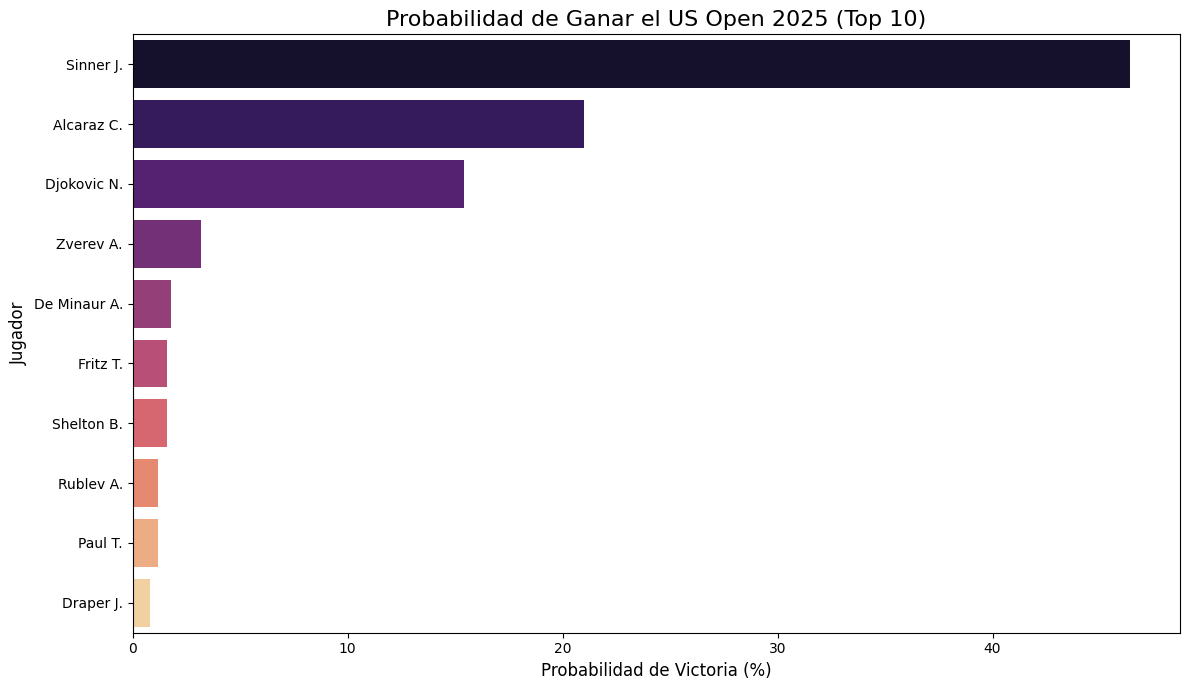

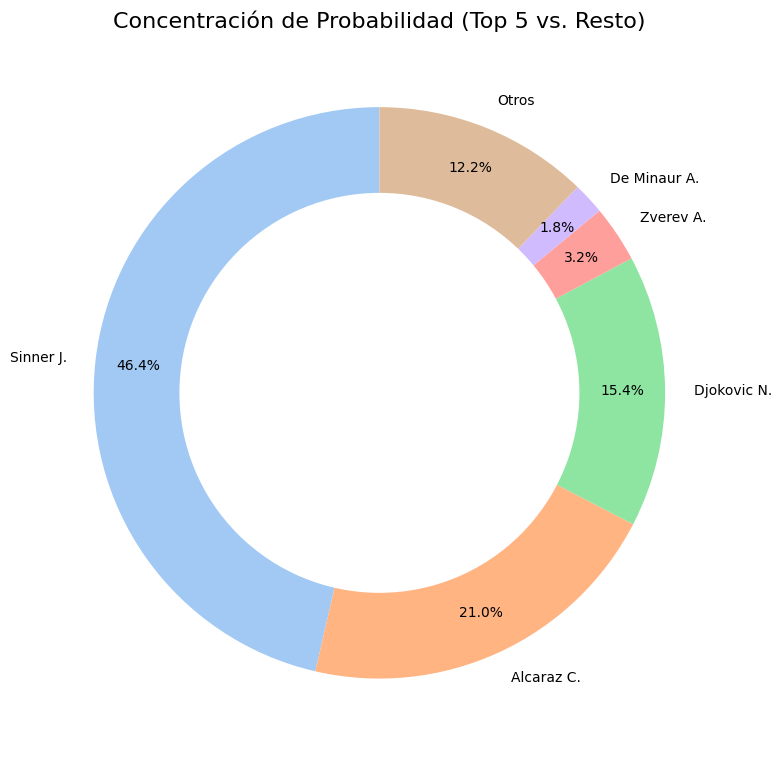

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que 'probabilidad_campeonato' es el diccionario ordenado final:
# Ejemplo: {'Djokovic N.': 0.35, 'Alcaraz C.': 0.28, ...}

# 1. Convertir el diccionario de resultados a DataFrame
df_resultados = pd.DataFrame(
    list(probabilidad_campeonato.items()), 
    columns=['Jugador', 'Probabilidad_Campeonato']
)

# 2. Calcular la Probabilidad en Porcentaje
df_resultados['Probabilidad_%'] = (df_resultados['Probabilidad_Campeonato'] * 100).round(2)

# --- ANÁLISIS 1: BARRAS (TOP 10 CANDIDATOS) ---

df_top10 = df_resultados.head(10)

plt.figure(figsize=(12, 7))
sns.barplot(
    x='Probabilidad_%', 
    y='Jugador', 
    data=df_top10, 
    palette='magma' 
)
plt.title('Probabilidad de Ganar el US Open 2025 (Top 10)', fontsize=16)
plt.xlabel('Probabilidad de Victoria (%)', fontsize=12)
plt.ylabel('Jugador', fontsize=12)
plt.tight_layout()
# La imagen se mostrará automáticamente al final de la celda.

# --- ANÁLISIS 2: CIRCULAR (TOP 5 CONCENTRACIÓN) ---

df_top5 = df_resultados.head(5).copy()
# Agrupar el resto en una categoría "Otros"
prob_otros = df_resultados['Probabilidad_Campeonato'].iloc[5:].sum()
df_resto = pd.DataFrame([['Otros', prob_otros, prob_otros * 100]], columns=df_top5.columns)

df_pie = pd.concat([df_top5, df_resto], ignore_index=True)

plt.figure(figsize=(8, 8))
plt.pie(
    df_pie['Probabilidad_Campeonato'], 
    labels=df_pie['Jugador'], 
    autopct=lambda p: f'{p:.1f}%' if p > 1.0 else '', 
    startangle=90,
    pctdistance=0.85,
    colors=sns.color_palette('pastel')
)
# Agregar un círculo central para hacerlo un "Donut Chart"
center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.title('Concentración de Probabilidad (Top 5 vs. Resto)', fontsize=16)
plt.tight_layout()
# La segunda imagen se mostrará automáticamente debajo de la primera.

# 3. Imprimir la tabla de resultados
print("\n--- 🏆 TABLA DE PREDICCIÓN FINAL (MONTE CARLO) ---")
print(df_resultados.head(10).to_string(index=False))